In [2]:
# import libraries
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
# CSV 불러오기
df = pd.read_csv("cs_data.csv")
df.head()

,paper_id,doi,title,year,type,cited_by_count,language,updated_date,venue_name,venue_type,...,first_author_name,last_author_name,is_corresponding_author_list,num_authors,concept_ids,concept_names,concept_levels,concept_scores,referenced_works,num_concepts
0,https://openalex.org/W3010906965,https://doi.org/10.1039/d0cp00502a,Extension and evaluation of the D4 London-disp...,2020,article,321,en,2025-08-27T07:13:42.282366,Physical Chemistry Chemical Physics,journal,...,Eike Caldeweyher,Stefan Grimme,False;False;False;True,4,https://openalex.org/C2778029271;https://opena...,Extension (predicate logic);Dispersion (optics...,2;2;1;0;0;0;1;1,0.8126453;0.5636233;0.41000125;0.36818647;0.31...,https://openalex.org/W1649493451;https://opena...,8
1,https://openalex.org/W4213446860,https://doi.org/10.1109/tsp.2022.3153135,Robust Aggregation for Federated Learning,2022,article,342,en,2025-08-26T16:37:21.303548,IEEE Transactions on Signal Processing,journal,...,Krishna Pillutla,Zaïd Harchaoui,False;False;False,3,https://openalex.org/C63479239;https://openale...,Robustness (evolution);Computer science;Oracle...,3;0;2;2;2;4;2;3;1;1;2;1;1;0;1;2;0;3;2;1;1,0.8185373;0.80663997;0.8028511;0.53493685;0.49...,https://openalex.org/W1505731132;https://opena...,21
2,https://openalex.org/W2987460522,https://doi.org/10.1109/iccv.2019.00411,Learning the Model Update for Siamese Trackers,2019,article,379,en,2025-08-25T04:44:16.401159,2021 IEEE/CVF International Conference on Comp...,conference,...,Lichao Zhang,Fahad Shahbaz Khan,False;False;False;False;False,5,https://openalex.org/C41008148;https://openale...,Computer science;BitTorrent tracker;Frame (net...,0;3;2;1;2;2;3;2;1;2;2;0;1;1,0.80656606;0.7551134;0.71667755;0.65884244;0.6...,https://openalex.org/W1517850131;https://opena...,14
3,https://openalex.org/W3133928066,https://doi.org/10.1016/j.jclepro.2021.126655,Industry 4.0 and sustainable development: A sy...,2021,article,373,en,2025-08-26T18:40:26.394195,Journal of Cleaner Production,journal,...,Iqra Sadaf Khan,Jukka Majava,True;False;False,3,https://openalex.org/C6165555;https://openalex...,Triple bottom line;Circular economy;Sustainabi...,3;2;2;2;3;2;2;0;2;2;1;1;1;0;0;0;0;1;1;1;0;1,0.9426188;0.7344366;0.7067074;0.64187956;0.590...,https://openalex.org/W1099650174;https://opena...,22
4,https://openalex.org/W4382464460,https://doi.org/10.1609/aaai.v37i2.25233,BEVDepth: Acquisition of Reliable Depth for Mu...,2023,article,343,en,2025-09-01T14:52:09.202086,Proceedings of the AAAI Conference on Artifici...,conference,...,Yinhao Li,Zeming Li,False;False;False;False;False;False;False;False,8,https://openalex.org/C41008148;https://openale...,Computer science;Artificial intelligence;Compu...,0;1;1;2;3;2;2;2;2;3;2;1;2;2;1;1,0.7693159;0.72026145;0.7065186;0.6600003;0.579...,https://openalex.org/W2150066425;https://opena...,16


In [6]:
# 문자열 → 리스트 변환 함수
def parse_refs(ref_str):
    if pd.isna(ref_str): return []
    return ref_str.split(';')

def parse_concepts(concept_str):
    if pd.isna(concept_str): return []
    return concept_str.split(';')

def parse_authors(author_str):
    if pd.isna(author_str): return []
    return [a.strip().lower() for a in author_str.split(';')]

# 컬럼 변환
df['ref_list'] = df['referenced_works'].apply(parse_refs)
df['concept_list'] = df['concept_names'].apply(parse_concepts)
df['author_list'] = df['author_names'].apply(parse_authors)

# 전체 노드 집합
all_papers = set(df['paper_id'])
all_authors = set(itertools.chain.from_iterable(df['author_list']))
all_concepts = set(itertools.chain.from_iterable(df['concept_list']))


앵커 엣지 (ground truth) 추출

In [9]:
# 1) cited_by (paper–paper)
positive_cited_by = [(p, r) for p, refs in zip(df['paper_id'], df['ref_list']) for r in refs if r in all_papers]

# 2) worked_with (author–author)
positive_worked_with = []
for authors in df['author_list']:
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            positive_worked_with.append((authors[i], authors[j]))

# 3) has_topic (paper–concept)
positive_has_topic = [(p, c) for p, concepts in zip(df['paper_id'], df['concept_list']) for c in concepts]

# 4) wrote (author–paper)
positive_wrote = [(a, p) for p, authors in zip(df['paper_id'], df['author_list']) for a in authors]


Positive Pair 생성 (augmentation 방식) 

In [12]:
def make_positive_pairs(anchor_edges):
    pos_pairs = []
    for u, v in anchor_edges:
        pos_pairs.append((f"{u}#v1", f"{v}#v2"))
    return pos_pairs

pos_cited_by = make_positive_pairs(positive_cited_by)
pos_worked_with = make_positive_pairs(positive_worked_with)
pos_has_topic = make_positive_pairs(positive_has_topic)
pos_wrote = make_positive_pairs(positive_wrote)


Negative Pair 생성 (Naive + Hard Negative) 
- Naive: 무작위 쌍, 실제 앵커에 없는 경우만
- Hard: 주제가 유사하지만 관계가 없는 경우

In [15]:
def make_negative_pairs(anchor_edges, nodes_u, nodes_v=None, hard=False, sample_size=None):
    neg_pairs = []
    anchor_set = set(anchor_edges)
    nodes_v = nodes_v if nodes_v is not None else nodes_u
    count = sample_size or len(anchor_edges)

    while len(neg_pairs) < count:
        u, v = random.sample(nodes_u, 1)[0], random.sample(nodes_v, 1)[0]
        if (u, v) in anchor_set or (v, u) in anchor_set or u == v:
            continue

        # Hard negative 조건 (예: 논문-논문에서 concept 겹침)
        if hard:
            if isinstance(u, str) and u.startswith("http") and isinstance(v, str) and v.startswith("http"):
                cu = set(df.loc[df['paper_id']==u, 'concept_list'].values[0])
                cv = set(df.loc[df['paper_id']==v, 'concept_list'].values[0])
                if len(cu & cv) == 0:  # 공통 concept 없으면 hard로 채택하지 않음
                    continue
        neg_pairs.append((u, v))
    return neg_pairs

# Negative 생성
neg_cited_by = make_negative_pairs(positive_cited_by, list(all_papers), hard=True, sample_size=len(pos_cited_by))
neg_worked_with = make_negative_pairs(positive_worked_with, list(all_authors), hard=False, sample_size=len(pos_worked_with))
neg_has_topic = make_negative_pairs(positive_has_topic, list(all_papers), list(all_concepts), hard=False, sample_size=len(pos_has_topic))
neg_wrote = make_negative_pairs(positive_wrote, list(all_authors), list(all_papers), hard=False, sample_size=len(pos_wrote))


CSV로 저장

In [17]:
def save_pairs(pos_pairs, neg_pairs, filename):
    df_pos = pd.DataFrame({"positive": [f"{u},{v}" for u,v in pos_pairs],
                           "negative": ["" for _ in pos_pairs],
                           "label": 1})
    df_neg = pd.DataFrame({"positive": ["" for _ in neg_pairs],
                           "negative": [f"{u},{v}" for u,v in neg_pairs],
                           "label": 0})
    df_all = pd.concat([df_pos, df_neg]).sample(frac=1).reset_index(drop=True)
    df_all.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(df_all)} rows")

save_pairs(pos_cited_by, neg_cited_by, "pairs_cited_by.csv")
save_pairs(pos_worked_with, neg_worked_with, "pairs_worked_with.csv")
save_pairs(pos_has_topic, neg_has_topic, "pairs_has_topic.csv")
save_pairs(pos_wrote, neg_wrote, "pairs_wrote.csv")


Saved pairs_cited_by.csv with 16372 rows
Saved pairs_worked_with.csv with 1157776 rows
Saved pairs_has_topic.csv with 164476 rows
Saved pairs_wrote.csv with 81516 rows


통계 분석

In [19]:
def pair_statistics(pos_pairs, neg_pairs, name="Dataset"):
    num_pos = len(pos_pairs)
    num_neg = len(neg_pairs)
    nodes = [u for u,v in pos_pairs] + [v for u,v in pos_pairs]
    counts = Counter(nodes)
    return {
        "dataset": name,
        "num_positive": num_pos,
        "num_negative": num_neg,
        "avg_degree_pos": np.mean(list(counts.values())) if counts else 0
    }

print(pair_statistics(pos_cited_by, neg_cited_by, "cited_by"))
print(pair_statistics(pos_worked_with, neg_worked_with, "worked_with"))
print(pair_statistics(pos_has_topic, neg_has_topic, "has_topic"))
print(pair_statistics(pos_wrote, neg_wrote, "wrote"))


{'dataset': 'cited_by', 'num_positive': 8186, 'num_negative': 8186, 'avg_degree_pos': 3.2882104840329385}
{'dataset': 'worked_with', 'num_positive': 578888, 'num_negative': 578888, 'avg_degree_pos': 19.943431002704425}
{'dataset': 'has_topic', 'num_positive': 82238, 'num_negative': 82238, 'avg_degree_pos': 13.820351230988992}
{'dataset': 'wrote', 'num_positive': 40758, 'num_negative': 40758, 'avg_degree_pos': 2.17376}


노드별 연결 분포 시각화

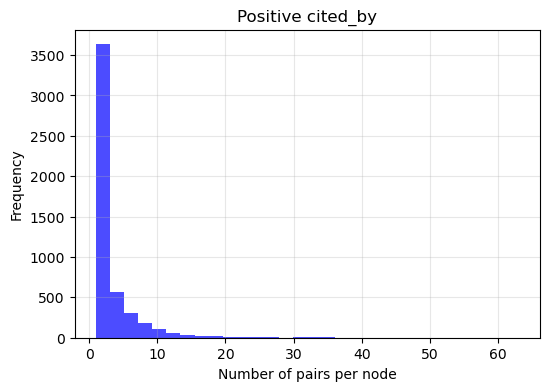

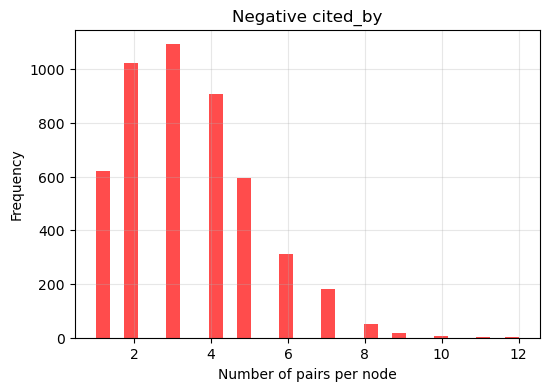

In [21]:
# 공통 히스토그램 함수
def plot_hist(pairs, title, color):
    nodes = [u for u,v in pairs] + [v for u,v in pairs]
    counts = Counter(nodes)
    plt.figure(figsize=(6,4))
    plt.hist(list(counts.values()), bins=30, color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel("Number of pairs per node")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

# 1) cited_by
plot_hist(pos_cited_by, "Positive cited_by", "blue")
plot_hist(neg_cited_by, "Negative cited_by", "red")


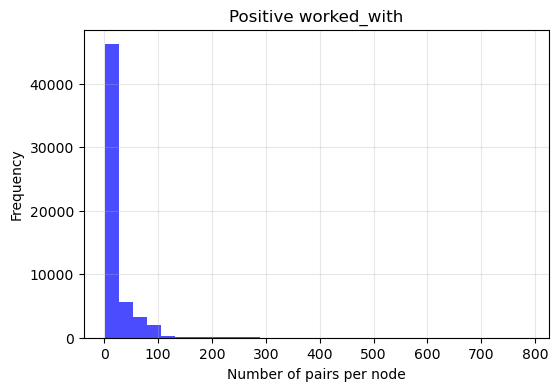

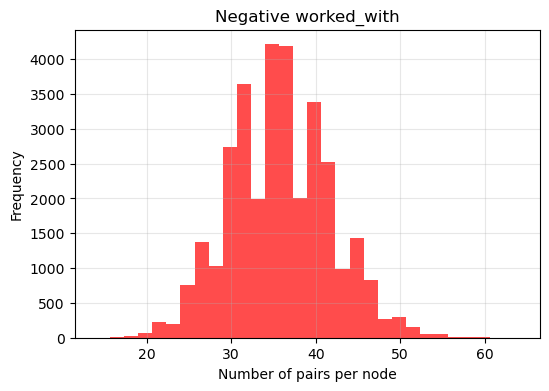

In [22]:
# 2) worked_with
plot_hist(pos_worked_with, "Positive worked_with", "blue")
plot_hist(neg_worked_with, "Negative worked_with", "red")

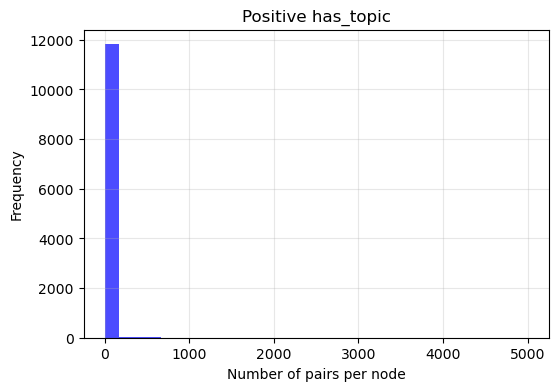

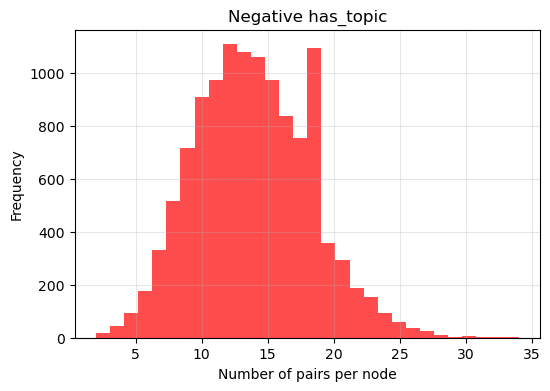

In [23]:
# 3) has_topic
plot_hist(pos_has_topic, "Positive has_topic", "blue")
plot_hist(neg_has_topic, "Negative has_topic", "red")

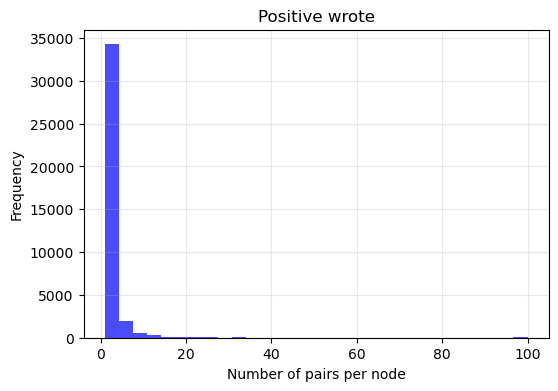

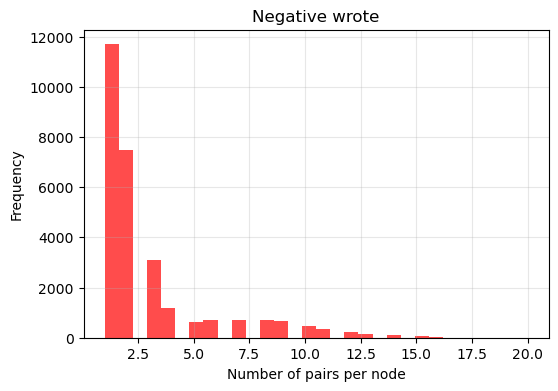

In [24]:
# 4) wrote
plot_hist(pos_wrote, "Positive wrote", "blue")
plot_hist(neg_wrote, "Negative wrote", "red")

negative pair의 hardness 확인 + 시각화

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

pairs = pd.read_csv("pairs_cited_by.csv")  # 예: cited_by용 CSV
pairs = pairs.fillna("")

In [35]:
# 그래프 만들기 (ground truth 앵커 엣지 기반)
#    - positive 컬럼에 있는 엣지 + 원래 앵커 엣지를 그래프로 구축

G = nx.Graph()

In [37]:
# 논문-논문 citation edge 불러오기
# (실제 ground truth 앵커 엣지가 따로 있다면 그걸로 추가해도 됨)
for row in pairs.itertuples():
    if row.positive != "":
        u, v = row.positive.split(",")
        # view 태그 제거 (#v1, #v2)
        u, v = u.split("#")[0], v.split("#")[0]
        G.add_edge(u, v)

In [39]:
# Negative pair hop distance 계산
hop_distances = []
for row in pairs.itertuples():
    if row.label == 0 and row.negative != "":
        u, v = row.negative.split(",")
        if u in G and v in G:
            try:
                d = nx.shortest_path_length(G, source=u, target=v)
                hop_distances.append(d)
            except nx.NetworkXNoPath:
                hop_distances.append(-1)  # 연결 경로 없음
        else:
            hop_distances.append(-1)  # 그래프에 없는 노드

In [41]:
# 분포 집계 및 시각화
dist_counter = Counter(hop_distances)

print("Hop distribution (negative pairs):")
for dist, cnt in sorted(dist_counter.items()):
    print(f"{dist} hop: {cnt} pairs")

Hop distribution (negative pairs):
-1 hop: 5765 pairs
2 hop: 26 pairs
3 hop: 75 pairs
4 hop: 187 pairs
5 hop: 301 pairs
6 hop: 325 pairs
7 hop: 333 pairs
8 hop: 341 pairs
9 hop: 232 pairs
10 hop: 192 pairs
11 hop: 133 pairs
12 hop: 111 pairs
13 hop: 66 pairs
14 hop: 45 pairs
15 hop: 22 pairs
16 hop: 14 pairs
17 hop: 9 pairs
18 hop: 7 pairs
21 hop: 2 pairs


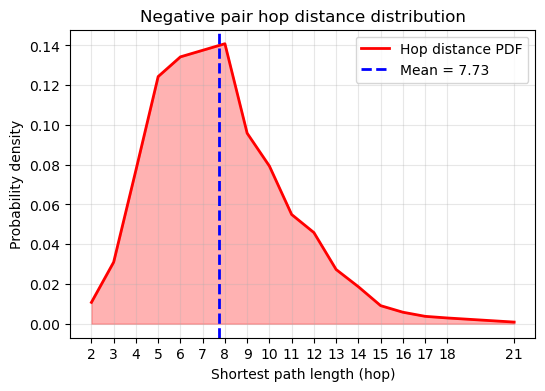

In [43]:
import numpy as np

# hop_distances: 앞에서 구한 negative pair들의 hop 거리 리스트
valid_distances = [d for d in hop_distances if d >= 0]

# hop 값별 확률밀도 계산
values, counts = np.unique(valid_distances, return_counts=True)
pdf = counts / counts.sum()  # 확률밀도 (합=1)

# 평균 계산
mean_hop = np.mean(valid_distances)

# 면적 채운 꺾은선 그래프
plt.figure(figsize=(6,4))
plt.plot(values, pdf, color="red", linewidth=2, label="Hop distance PDF")
plt.fill_between(values, pdf, color="red", alpha=0.3)  # 면적 채우기

# 평균선 표시
plt.axvline(mean_hop, color="blue", linestyle="--", linewidth=2, label=f"Mean = {mean_hop:.2f}")

# 그래프 꾸미기
plt.title("Negative pair hop distance distribution")
plt.xlabel("Shortest path length (hop)")
plt.ylabel("Probability density")
plt.xticks(values)  # hop 값만 x축에 표시
plt.legend()
plt.grid(alpha=0.3)
plt.show()
